In [2]:
# Import basic libraries to handle data and build the model
import zipfile
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms
from torch.utils.data import random_split
import torch.nn.functional as F

In [3]:
!git clone https://github.com/Prashant-AV/Qualcomm-DL-Hackathon.git

Cloning into 'Qualcomm-DL-Hackathon'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 30.68 MiB | 17.99 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [4]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
os.chdir("/content/Qualcomm-DL-Hackathon/train")
extract_dir = "/content/Qualcomm-DL-Hackathon/train/"
os.makedirs(extract_dir, exist_ok=True)

# Open and extract the zip file
with zipfile.ZipFile("images part-1.zip", 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
with zipfile.ZipFile("images part-2.zip", 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print(f"Contents extracted to {extract_dir}")

Contents extracted to /content/Qualcomm-DL-Hackathon/train/


In [6]:
os.rename('/content/Qualcomm-DL-Hackathon/train/images part-1', '/content/Qualcomm-DL-Hackathon/train/images')

In [7]:
import shutil
for x in os.listdir('/content/Qualcomm-DL-Hackathon/train/images part-2'):
  source_path = os.path.join('/content/Qualcomm-DL-Hackathon/train/images part-2', x)
  shutil.move(source_path, '/content/Qualcomm-DL-Hackathon/train/images/')

In [8]:
#shutil.rmtree('/content/Qualcomm-DL-Hackathon/train/images')
shutil.rmtree('/content/Qualcomm-DL-Hackathon/train/images part-2')

In [9]:
from PIL import Image
os.getcwd()

'/content/Qualcomm-DL-Hackathon/train'

In [10]:
#reading images to check size
count = 0
for x in os.listdir('/content/Qualcomm-DL-Hackathon/train/images/'):
  img = Image.open('/content/Qualcomm-DL-Hackathon/train/images/'+x)
  count+=1
count, img.size

(2352, (224, 224))

In [11]:
import numpy as np
import pandas as pd

In [12]:
os.chdir("/content/Qualcomm-DL-Hackathon/train/")

In [13]:
pd.read_csv('train.csv').head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [14]:
pd.read_csv('train.csv').shape

(1646, 2)

In [15]:
aug_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
])

In [16]:
def load_and_augment_images(image_folder, csv_file, transform):
    augmented_data = []
    df = pd.read_csv(csv_file)
    for index, row in df.iterrows():
        img_path = os.path.join(image_folder, row['image_names'])
        img = Image.open(img_path)

        # Save original image info
        augmented_data.append({'image_names': row['image_names'], 'label': row['emergency_or_not']})

        for i in range(4):  # Generate 4 augmented images per original image
            augmented_img = transform(img)
            save_path = os.path.join('/content/Qualcomm-DL-Hackathon/train/images/', f"aug_{index}_{i}.jpg")
            save_image(augmented_img, save_path)
            augmented_data.append({'image_names': f"aug_{index}_{i}.jpg", 'label': row['emergency_or_not']})

    augmented_df = pd.DataFrame(augmented_data)
    augmented_df.to_csv('aug_train.csv', index=False)

def save_image(image, path):
    image.save(path, format='jpeg')

In [17]:
load_and_augment_images(image_folder='images', csv_file='/content/Qualcomm-DL-Hackathon/train/train.csv', transform=aug_transform)

In [18]:
pd.read_csv('aug_train.csv').head(30)

,image_names,label
0,1503.jpg,0
1,aug_0_0.jpg,0
2,aug_0_1.jpg,0
3,aug_0_2.jpg,0
4,aug_0_3.jpg,0
5,1420.jpg,0
6,aug_1_0.jpg,0
7,aug_1_1.jpg,0
8,aug_1_2.jpg,0
9,aug_1_3.jpg,0


In [19]:
pd.read_csv('aug_train.csv').shape

(8230, 2)

In [20]:
# creating transforms to resize and normalize te features based on imagenet standards
t_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet mean/std
])


In [21]:
# creating customdataset for transforming images to tensors and returning image tensors and labels
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, train=True):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)

        if self.train:
            label = self.data.iloc[idx, 1]
            return image, label
        else:
            return image

In [22]:
# creating Datasets for training and testing
train_dataset = CustomDataset(csv_file='/content/Qualcomm-DL-Hackathon/train/aug_train.csv', root_dir='images', transform=t_transforms)
test_dataset = CustomDataset(csv_file='/content/Qualcomm-DL-Hackathon/test.csv', root_dir='images', transform=t_transforms, train=False)


In [23]:
# Split training data into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

In [24]:
train_size, val_size

(6584, 1646)

In [25]:
# creating data loaders in the batches of size 32
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [26]:
class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expand_ratio, stride, kernel_size):
        super(MBConvBlock, self).__init__()
        self.stride = stride
        hidden_dim = in_channels * expand_ratio
        self.use_residual = self.stride == 1 and in_channels == out_channels

        layers = []
        if expand_ratio != 1:
            layers.append(nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.SiLU())

        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        ])

        self.block = nn.Sequential(*layers)
        self.se = SqueezeExcitation(hidden_dim)

    def forward(self, x):
        if self.use_residual:
            return x + self.block(x)
        else:
            return self.block(x)

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super(SqueezeExcitation, self).__init__()
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)

    def forward(self, x):
        scale = F.adaptive_avg_pool2d(x, 1)
        scale = F.silu(self.fc1(scale))
        scale = torch.sigmoid(self.fc2(scale))
        return x * scale

class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=2):
        super(EfficientNetB0, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.SiLU()
        )
        self.blocks = nn.Sequential(
            MBConvBlock(32, 16, expand_ratio=1, stride=1, kernel_size=3),
            MBConvBlock(16, 24, expand_ratio=6, stride=2, kernel_size=3),
            MBConvBlock(24, 24, expand_ratio=6, stride=1, kernel_size=3),
            MBConvBlock(24, 40, expand_ratio=6, stride=2, kernel_size=5),
            MBConvBlock(40, 40, expand_ratio=6, stride=1, kernel_size=5),
            MBConvBlock(40, 80, expand_ratio=6, stride=2, kernel_size=3),
            MBConvBlock(80, 80, expand_ratio=6, stride=1, kernel_size=3),
            MBConvBlock(80, 80, expand_ratio=6, stride=1, kernel_size=3),
            MBConvBlock(80, 112, expand_ratio=6, stride=1, kernel_size=5),
            MBConvBlock(112, 112, expand_ratio=6, stride=1, kernel_size=5),
            MBConvBlock(112, 112, expand_ratio=6, stride=1, kernel_size=5),
            MBConvBlock(112, 192, expand_ratio=6, stride=2, kernel_size=5),
            MBConvBlock(192, 192, expand_ratio=6, stride=1, kernel_size=5),
            MBConvBlock(192, 192, expand_ratio=6, stride=1, kernel_size=5),
            MBConvBlock(192, 192, expand_ratio=6, stride=1, kernel_size=5),
            MBConvBlock(192, 320, expand_ratio=6, stride=1, kernel_size=3)
        )
        self.head = nn.Sequential(
            nn.Conv2d(320, 1280, kernel_size=1, bias=False),
            nn.BatchNorm2d(1280),
            nn.SiLU()
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Instantiate the model
model = EfficientNetB0(num_classes=2)
model = model.to(device)

In [27]:
# choosing Efficient net architecture as it is best for image classification tasks
#model = EfficientNet.from_pretrained('efficientnet-b0')  # choosing model B0 as it is smallest and least computational.
#num_ftrs = model._fc.in_features
##print(num_ftrs)
#model._fc = nn.Linear(num_ftrs, 2)  # 2 classes: emergency and non-emergency
#model = model.to(device)

In [28]:
# Defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # for classification
optimizer = optim.Adam(model.parameters(), lr=0.001) #optimiser with learning rate 0.001

In [29]:
#training the model on internally split train data
num_epochs = 10
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    if epoch_acc > best_accuracy:
        best_accuracy = epoch_acc

print(f'Best Validation Accuracy: {best_accuracy:.2f}%')

torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/10, Loss: 0.5641, Accuracy: 72.49%
Epoch 2/10, Loss: 0.4577, Accuracy: 79.04%
Epoch 3/10, Loss: 0.3786, Accuracy: 84.19%
Epoch 4/10, Loss: 0.3138, Accuracy: 87.23%
Epoch 5/10, Loss: 0.2666, Accuracy: 88.90%
Epoch 6/10, Loss: 0.2110, Accuracy: 91.46%
Epoch 7/10, Loss: 0.1808, Accuracy: 92.92%
Epoch 8/10, Loss: 0.1494, Accuracy: 93.97%
Epoch 9/10, Loss: 0.1325, Accuracy: 94.87%
Epoch 10/10, Loss: 0.0963, Accuracy: 96.39%
Best Validation Accuracy: 96.39%


In [30]:
# importing necessary libraries for printing evaluation metrics
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       959
           1       0.85      0.78      0.81       687

    accuracy                           0.85      1646
   macro avg       0.85      0.84      0.84      1646
weighted avg       0.85      0.85      0.85      1646



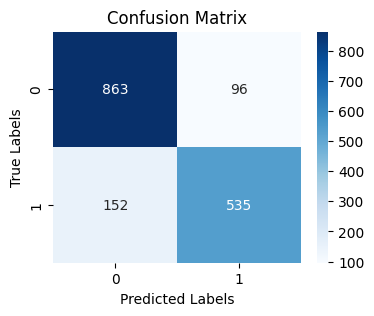

Validation Accuracy: 84.93%


In [32]:
#Evaluating model on internal test data val_dataset and printing evaluation metrics
model.eval()
val_labels = []
val_predictions = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        val_labels.extend(labels.cpu().numpy())  # Collect true labels
        val_predictions.extend(predicted.cpu().numpy())  # Collect predicted labels

# Generate the confusion matrix
cm = confusion_matrix(val_labels, val_predictions)
cr=classification_report(val_labels, val_predictions)

print(cr)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print the test accuracy
val_accuracy = 100 * sum(np.array(val_labels) == np.array(val_predictions)) / len(val_labels)
print(f'Validation Accuracy: {val_accuracy:.2f}%')


In [33]:
# evaluating images in test.csv file and writing predictions
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
predictions = []

with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

# Save predictions to CSV
test_data = pd.read_csv('/content/Qualcomm-DL-Hackathon/test.csv')
test_data['emergency_or_not'] = predictions
test_data.to_csv('/content/Qualcomm-DL-Hackathon/test_predictions.csv', index=False)
print('labels written to test_prediction.csv')

<ipython-input-33-8410d59754f6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


labels written to test_prediction.csv
